In [7]:
# from sst and rainfall ---> rainfall
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
import tensorflow.compat.v1 as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv3D, Conv2D
from keras.layers import ConvLSTM2D
from keras.layers import Attention
from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout, Lambda
from keras import optimizers
from keras.layers import Conv2DTranspose, TimeDistributed
from keras import callbacks
import xarray as xr

# Define global variables
lead_time = 0
save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in1out/"
model_path = save_path + "ConvLstm_sst0rf_rf_0bob.h5"
add_data = "/home/cccr/roxy/matin/MTech_project/data/"

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("1998-01-01","2016-12-31"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out


channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target

# Perform additional processing or modeling steps as needed
seq = tf.keras.Sequential()

# Add layers to the model
seq.add(ConvLSTM2D(filters=4, kernel_size=(3,3), padding='same', input_shape=(7,25,39,2), return_sequences=True, data_format='channels_last'))
seq.add(ConvLSTM2D(filters=8, kernel_size=(3,3), padding='same', return_sequences=True, data_format='channels_last'))
seq.add(ConvLSTM2D(filters=8, kernel_size=(3,3), padding='same', return_sequences=True, data_format='channels_last'))
seq.add(ConvLSTM2D(filters=16, kernel_size=(3,3), padding='same', return_sequences=True, data_format='channels_last'))
seq.add(ConvLSTM2D(filters=16, kernel_size=(3,3), padding='same', return_sequences=False, data_format='channels_last'))
seq.add(Conv2D(filters=15, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_last'))
seq.add(Conv2D(filters=1, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_last'))
# Create the query, value, and key inputs
query_input = Input(shape=(25,39,2), name='query_input')
value_input = Input(shape=(25,39,2), name='value_input')
key_input = Input(shape=(25,39,2), name='key_input')

# Pass the inputs to the Attention layer
attention_output = Attention(name='attention')([query_input, value_input, key_input])
Adam = tf.keras.optimizers.Adam(learning_rate=10**-4)
seq.compile(loss='mean_squared_error', optimizer=Adam, metrics=['mae'])

print(seq.summary())

# Define the number of training epochs
n_epochs = 200
logdir = save_path
# Define the TensorBoard callback for monitoring training progress
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=10, batch_size=10, write_graph=True)

# Define the ReduceLROnPlateau callback for reducing the learning rate when the model plateaus
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=10**-20)

# Define the ModelCheckpoint callback for saving the best model based on validation mean absolute error
checkpoint_callback_mae = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mae',
                                                             mode='min', save_best_only=True)

# Define the ModelCheckpoint callback for saving the best model based on validation loss
checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',
                                                              mode='min', save_best_only=True)

# Define the EarlyStopping callback for stopping training when the model stops improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

# Define the TerminateOnNaN callback for terminating the training process if there is NaN value in any of the output
terminate_callback = tf.keras.callbacks.TerminateOnNaN()

# Train the model using the defined callbacks
history = seq.fit(x, y, epochs=n_epochs, validation_split=0.1,
                  batch_size=50, callbacks=[early_stop_callback,
                  checkpoint_callback_mae, checkpoint_callback_loss,
                  tb_callback, lr_callback, terminate_callback])
#Save the trained model
seq.save(model_path)

#Save the training history

np.save(f'{save_path}ConvLstm_sst0rf_rf_0bob.npy', history.history)               
              

Adding channel 0 with shape: (2311, 7, 1, 25, 39)
Adding channel 1 with shape: (2311, 7, 1, 25, 39)
INPUT SHAPE -->  (2311, 7, 2, 25, 39)
TARGET SHAPE -->  (2311, 1, 25, 39)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_5 (ConvLSTM2D)  (None, 7, 25, 39, 4)      880       
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 7, 25, 39, 8)      3488      
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 7, 25, 39, 8)      4640      
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 7, 25, 39, 16)     13888     
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, 25, 39, 16)        18496     
                                                                 
 conv2d_2 (C

Epoch 43/200
42/42 [==============================] - 281s 7s/step - loss: 1039.4121 - mae: 20.9492 - val_loss: 922.9057 - val_mae: 19.1747 - lr: 1.0000e-04
Epoch 44/200
42/42 [==============================] - 280s 7s/step - loss: 1039.4791 - mae: 20.9272 - val_loss: 923.0469 - val_mae: 19.2296 - lr: 1.0000e-04
Epoch 45/200
42/42 [==============================] - 265s 6s/step - loss: 1039.1685 - mae: 20.9148 - val_loss: 922.6938 - val_mae: 19.1770 - lr: 1.0000e-04
Epoch 46/200
42/42 [==============================] - 268s 6s/step - loss: 1039.0448 - mae: 20.9531 - val_loss: 922.6373 - val_mae: 19.1913 - lr: 1.0000e-04
Epoch 47/200
42/42 [==============================] - 257s 6s/step - loss: 1038.8492 - mae: 20.9273 - val_loss: 922.5462 - val_mae: 19.1964 - lr: 1.0000e-04
Epoch 48/200
42/42 [==============================] - 258s 6s/step - loss: 1038.7504 - mae: 20.9067 - val_loss: 922.3426 - val_mae: 19.1766 - lr: 1.0000e-04
Epoch 49/200
42/42 [==============================] - 249s

Epoch 95/200
42/42 [==============================] - 31s 728ms/step - loss: 284.4181 - mae: 8.1320 - val_loss: 238.2759 - val_mae: 7.3617 - lr: 1.0000e-04
Epoch 96/200
42/42 [==============================] - 31s 748ms/step - loss: 278.4230 - mae: 8.1112 - val_loss: 234.5515 - val_mae: 7.3179 - lr: 1.0000e-04
Epoch 97/200
42/42 [==============================] - 31s 741ms/step - loss: 269.2040 - mae: 7.9924 - val_loss: 220.7854 - val_mae: 7.0209 - lr: 1.0000e-04
Epoch 98/200
42/42 [==============================] - 33s 782ms/step - loss: 261.8547 - mae: 7.8797 - val_loss: 210.3031 - val_mae: 6.7414 - lr: 1.0000e-04
Epoch 99/200
42/42 [==============================] - 31s 739ms/step - loss: 256.3565 - mae: 7.8311 - val_loss: 206.1776 - val_mae: 6.8647 - lr: 1.0000e-04
Epoch 100/200
42/42 [==============================] - 31s 748ms/step - loss: 249.8222 - mae: 7.7304 - val_loss: 199.3227 - val_mae: 6.6994 - lr: 1.0000e-04
Epoch 101/200
42/42 [==============================] - 31s 738m

Epoch 200/200
42/42 [==============================] - 32s 770ms/step - loss: 85.2271 - mae: 4.6880 - val_loss: 61.9036 - val_mae: 3.6870 - lr: 1.0000e-04


In [29]:

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-01-01","2018-12-31"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out


channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target


Adding channel 0 with shape: (237, 7, 1, 25, 39)
Adding channel 1 with shape: (237, 7, 1, 25, 39)
INPUT SHAPE -->  (237, 7, 2, 25, 39)
TARGET SHAPE -->  (237, 1, 25, 39)


In [30]:
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
corr

8/8 [==============================] - 3s 98ms/step


array([[1.        , 0.90340841],
       [0.90340841, 1.        ]])

In [51]:

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-08-01","2017-08-09"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out


channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target



Adding channel 0 with shape: (2, 7, 1, 25, 39)
Adding channel 1 with shape: (2, 7, 1, 25, 39)
INPUT SHAPE -->  (2, 7, 2, 25, 39)
TARGET SHAPE -->  (2, 1, 25, 39)


In [59]:
x[0,:,:,:,0].shape

(7, 25, 39)

In [63]:
y[0,:,:,0].shape

(25, 39)

In [55]:
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
corr

1/1 [==============================] - 1s 931ms/step


array([[1.        , 0.88062869],
       [0.88062869, 1.        ]])

In [64]:
pred[0,:,:,0].shape

(25, 39)

In [114]:
a = xr.open_dataarray(add_data+"FilteredrfBOB_0lag.nc")[-518:-508]

sequence = xr.open_dataarray(add_data+"FilteredrfBOB_0lag.nc")[-518:-508]
max = sequence.max()
min = sequence.min()


# Max-min normalization
sequence = (sequence-min)/(max - min)
sequence = np.array(sequence)


# Exponential Space Transform
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.exp(sequence[valid_pts])
sequence[valid_pts] = np.power(sequence[valid_pts],7)
invalid_pts = np.where(sequence != sequence)
sequence[invalid_pts] = 0
Data = xr.DataArray(sequence,dims=('time', 'lat', 'lon'),coords={'time': a.time.data,'lat': a.lat.data,'lon':a.lon.data})





In [111]:
max - min

<xarray.DataArray ()>
array(1.25416642)

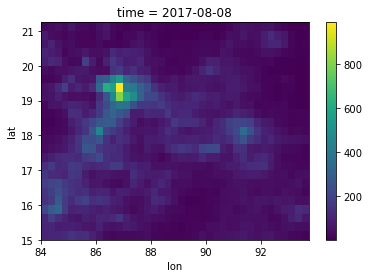

In [115]:
Data[7].plot()

In [116]:
sequence = Data.values
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=('time', 'lat', 'lon'),coords={'time': a.time.data,'lat': a.lat.data,'lon':a.lon.data})
sequence = sequence*(max - min)+min 


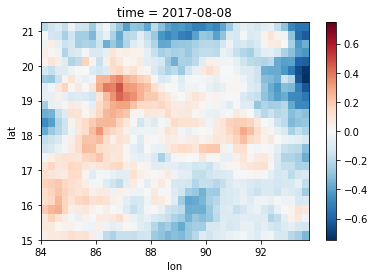

In [117]:
sequence[7].plot()

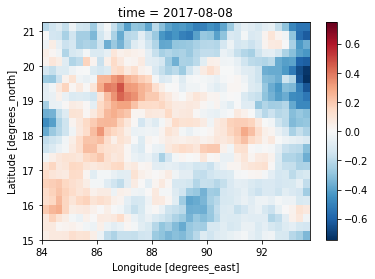

In [119]:
xr.open_dataarray(add_data+"FilteredrfBOB_0lag.nc")[-518:-508][7].plot()

In [ ]:
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)


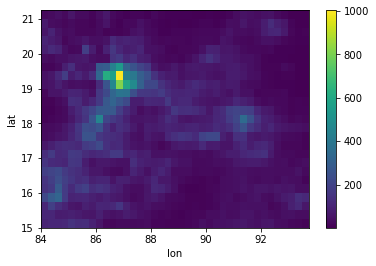

In [91]:
xr.DataArray(y[0,:,:,0],dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data}).plot()

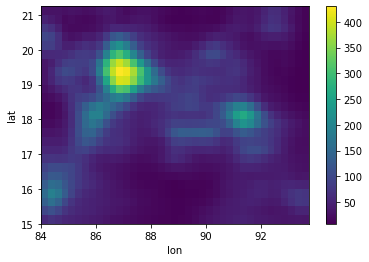

In [92]:
xr.DataArray(pred[0,:,:,0],dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data}).plot()

In [ ]:

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-08-01","2017-08-09"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out


channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target

